In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from google.colab import drive
drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/resized256'

for dirname, _, filenames in os.walk('/content/drive/MyDrive/resized256'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Mounted at /content/drive
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(100).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(12).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(1).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(10).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(11).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(25).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(20).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(18).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(15).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(28).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(24).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(3).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(30).jpg
/content/drive/MyDrive/resized256/Testing/glioma_tumor/image(17).jpg
/content/

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [3]:
import os
import cv2
import numpy as np

X_train = []  # List to store training images
Y_train = []  # List to store training labels

# List of image categories
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Loop through each category
for i in labels:
    # Path to the training images for the current category
    folderPath = os.path.join('/content/drive/MyDrive/resized256/Training', i)
    # Loop through each image in the category
    for j in os.listdir(folderPath):
        # Read the image
        img = cv2.imread(os.path.join(folderPath, j))
        # Check if the image was properly loaded
        if img is not None:
            # Resize the image
            img = cv2.resize(img, (150, 150))
            # Append the image to X_train
            X_train.append(img)
            # Append the label to Y_train
            Y_train.append(i)
        else:
            print(f"Unable to read image: {os.path.join(folderPath, j)}")

# Repeat the same process for testing images
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/resized256/Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img, (150, 150))
            X_train.append(img)
            Y_train.append(i)
        else:
            print(f"Unable to read image: {os.path.join(folderPath, j)}")

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)


Unable to read image: /content/drive/MyDrive/resized256/Training/glioma_tumor/MultiCNN.pth


augmentation

In [14]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2

# Example of data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

# Directory containing images for augmentation
input_dir = '/content/drive/MyDrive/resized256/Training/meningioma_tumor'
output_dir = '/content/drive/MyDrive/augmented_imagesMM'
os.makedirs(output_dir, exist_ok=True)

# Get list of image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Iterate over each image file
for filename in image_files:
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)
    data = img.reshape((1,) + img.shape)  # Reshape the data to (1, height, width, channels)

    # Generate augmented images and save them to the output directory
    for i, batch in enumerate(datagen.flow(data, batch_size=1)):
        augmented_image = batch[0].astype('uint8')

        # Save the augmented image
        save_path = os.path.join(output_dir, f'augmented_{filename}_{i}.jpg')
        plt.imsave(save_path, augmented_image)

        if i >= 3:  # Generate 3 augmented images per original image
            break





In [4]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(3928, 150, 150, 3)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(150,150,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [10]:
history = model.fit(X_train,y_train,epochs=20,validation_split=0.1)

Epoch 1/20
100/100 [==============================] - 585s 6s/step - loss: 1.6641 - accuracy: 0.3930 - val_loss: 1.2139 - val_accuracy: 0.5424
Epoch 2/20
100/100 [==============================] - 587s 6s/step - loss: 1.0761 - accuracy: 0.5426 - val_loss: 1.0582 - val_accuracy: 0.5763
Epoch 3/20
100/100 [==============================] - 577s 6s/step - loss: 0.8764 - accuracy: 0.6278 - val_loss: 0.8642 - val_accuracy: 0.6356
Epoch 4/20
100/100 [==============================] - 578s 6s/step - loss: 0.7733 - accuracy: 0.6740 - val_loss: 0.8360 - val_accuracy: 0.6751
Epoch 5/20
100/100 [==============================] - 581s 6s/step - loss: 0.6609 - accuracy: 0.7331 - val_loss: 0.6597 - val_accuracy: 0.7429
Epoch 6/20
100/100 [==============================] - 585s 6s/step - loss: 0.5663 - accuracy: 0.7749 - val_loss: 0.7163 - val_accuracy: 0.6836
Epoch 7/20
100/100 [==============================] - 584s 6s/step - loss: 0.4418 - accuracy: 0.8312 - val_loss: 0.7084 - val_accuracy: 0.7175

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

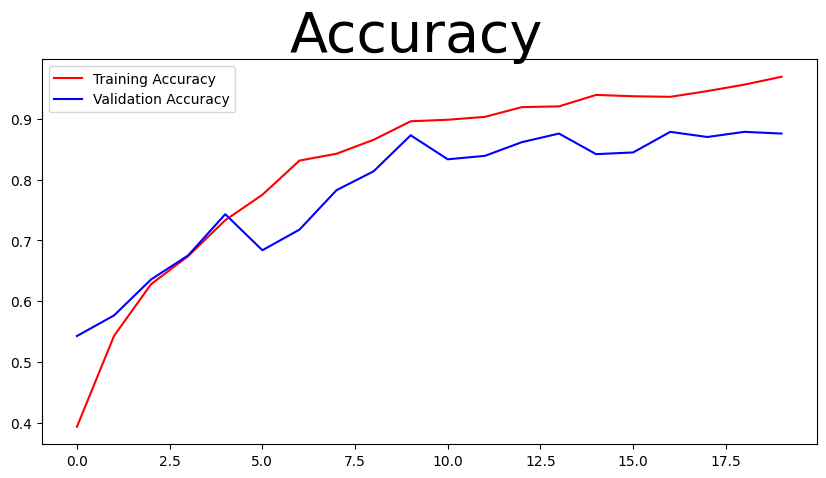

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,5))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
fig.suptitle('Accuracy', fontsize=40)
plt.legend(loc='upper left')
plt.show()